In [95]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import json


def zscore(series):
    return (series - series.mean()) / series.std()


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid(x, k=1, x0=0):
    return 1 / (1 + np.exp(-k * (x - x0)))


def adjusted_sigmoid(x, f_min=0.01, f_max=0.1, k=1, x0=0):
    return f_min + (f_max - f_min) * sigmoid(x, k=k, x0=x0)


def global_sigmoid(x, f_min, f_max, k=1, x0=0):
    if x > 0:
        return adjusted_sigmoid(x, f_min, f_max, k, x0)
    else:
        return adjusted_sigmoid(-x, f_min, f_max, k, x0)
    
    
def calculate_markout(d, v, f, p):
    m = d * v * (f - p)
    return m


data_p1 = pd.read_pickle('data/Merged_CEX_DEX_v2_p1.pkl')
data_p2 = pd.read_pickle('data/Merged_CEX_DEX_v2_p2.pkl')
data_p3 = pd.read_pickle('data/Merged_CEX_DEX_v2_p3.pkl')

data_p1['time'] = pd.to_datetime(data_p1['time'])
data_p2['time'] = pd.to_datetime(data_p2['time'])
data_p3['time'] = pd.to_datetime(data_p3['time'])

data = pd.concat([data_p1, data_p2, data_p3])
data = data.rename(columns={'LVR_clean': 'price_diff', 'LVR': 'arb_pnl' })
data = data.sort_values('time')

In [110]:
with open('gas_prices_final.json', 'r') as file:
    gas_price_eth = json.load(file)

data['impermanent_loss'] = (2 * np.sqrt(data['price_dex'].shift(1) / data['price_dex']) / (1 + data['price_dex'].shift(1) / data['price_dex']) - 1).fillna(0)
data['LVR_nbtoken']= data['arb_pnl']/data['price_dex']

data['avg_block_gas'] = data['blockNumber'].astype(str).map(gas_price_eth)
data['avg_gas']    = data['gasUsed'] * data['price_dex'] * data['avg_block_gas']
data['arb_fee']    = (np.abs(2*data['arb_pnl']) - (data['tcost_usd'] - data['avg_gas']))*100 / data['amountUSD']

data['LVR_zscore'] = zscore(data['arb_pnl'])

data['std']             = data['price_dex'].rolling(100).std()
data['mean_rol_amount'] = data['amountUSD'].rolling(10).mean()
data['rol_amountUSD']   = data['amountUSD'].rolling(100).sum()

# can be seen as looking ahead but in a DEX we can compute it aheat with the liquidity and the amount
data['price_impact']    = (data['price_dex'].pct_change(1).shift(-1)*100).abs()

data['time_diff']          = data['time'].diff().dt.total_seconds().fillna(0)

data['rol_1min_span']      = data['time_diff'].rolling(window=60, min_periods=1).sum() 
data['rol_1m_trade_count'] = data['time'].rolling(window=60, min_periods=1).count()
data['lambda_1min']        = data['rol_1m_trade_count'] / data['rol_1min_span']
data['lambda_1min'].replace([float('inf'), float('-inf'), pd.NA], 0, inplace=True)

data['rol_5min_span']      = data['time_diff'].rolling(window=60*5, min_periods=1).sum() 
data['rol_5m_trade_count'] = data['time'].rolling(window=60*5, min_periods=1).count()
data['lambda_5min']        = data['rol_5m_trade_count'] / data['rol_5min_span']
data['lambda_5min'].replace([float('inf'), float('-inf'), pd.NA], 0, inplace=True)
data = data.drop(columns=['time_diff'])

data['target_fee'] = (-np.sign(data['amount1']) * data['arb_fee']/100).clip(-0.1, 0.1)

data = data.dropna()

features = ['LVR_nbtoken', 'price_diff', 'arb_pnl', 'std', 'mean_rol_amount', 'avg_gas', 'price_impact', 'rol_amountUSD',
            'lambda_1min', 'rol_1min_span', 'rol_1m_trade_count', 
            'lambda_5min', 'rol_5min_span', 'rol_5m_trade_count', 'amountUSD']
target =  'target_fee' # 'tcost_usd'

lower_bound = data[features].quantile(0.05)
upper_bound = data[features].quantile(0.95)
filtered_indices = data[features].apply(lambda x: x.between(lower_bound[x.name], upper_bound[x.name])).all(axis=1)
data_filtered = data.loc[filtered_indices].copy()

f_min = 0.01
f_max = 0.1
w     = 0.04
k     = 1.75  # Steepness of the curve

params = {}
for f in features:
    params[f] = {'f_min': f_min, 'f_max': f_max, 'k': k, 'x0': (f_max-f_min)/(2*w)}
    
    
data_filtered

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,mean_rol_amount,rol_amountUSD,price_impact,rol_1min_span,rol_1m_trade_count,lambda_1min,rol_5min_span,rol_5m_trade_count,lambda_5min,target_fee
596,3454.673405,-1.505838,3457.185832,0xdd601697714d285aee8c1abfa3df7a2da3c5d731,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704078e+09,466191,9.486673e+09,9.486673e-09,...,6816.690597,1.737456e+06,0.000000,1212.0,60.0,0.049505,5136.0,300.0,0.058411,0.001653
599,-673.008000,0.293646,673.833366,0x42c7f7b3896391ef9e97386a6d23093b55744745,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704078e+09,281569,1.048868e+10,1.048868e-08,...,5723.321948,1.643696e+06,0.000000,1308.0,60.0,0.045872,5256.0,300.0,0.057078,-0.002495
600,-299.000000,0.130460,299.366986,0x9e0396350836ed26d5c78d9743c49a6a737440f1,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704078e+09,641134,1.273936e+10,1.273936e-08,...,5644.209015,1.631995e+06,0.000000,1380.0,60.0,0.043478,5292.0,300.0,0.056689,-0.008757
601,-229.189868,0.100000,229.471087,0x0dc89d5cfb8b4dfe0021c5f2f457689587ddcaec,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704078e+09,299490,1.273936e+10,1.273936e-08,...,5611.318148,1.632065e+06,0.000000,1380.0,60.0,0.043478,5292.0,300.0,0.056689,-0.005704
602,-116.886679,0.051000,117.030177,0xc5869b5e592143468007311f4b0bc2be40e3cee4,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0xef5edb29b4eb20501de89718daa7d1ad108efb66,1.704078e+09,445252,1.402652e+10,1.402652e-08,...,5572.984153,1.631952e+06,0.000000,1380.0,60.0,0.043478,5292.0,300.0,0.056689,-0.008236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187217,-150.000000,0.065775,149.978583,0xd132becd2e0a3c5d9d5b4c0fbdcc316ddf1d6e00,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706745e+09,641134,2.110782e+10,2.110782e-08,...,12610.913427,9.817162e+05,0.000000,1080.0,60.0,0.055556,4068.0,300.0,0.073746,-0.012648
187219,45889.218828,-20.100478,45857.693647,0x579f7f92092b522a068cda78a0d9daa13e7feef6,0xe37e799d5077682fa0a244d46e5649f71457bd09,0xe37e799d5077682fa0a244d46e5649f71457bd09,1.706745e+09,614176,2.350064e+10,2.350064e-08,...,16649.393470,1.065670e+06,0.019997,1080.0,60.0,0.055556,4032.0,300.0,0.074405,0.000586
187220,-4281.501296,1.877463,4280.921566,0xf865067a5b9672f11af8514440d9111afd05d040,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,606426,2.448898e+10,2.448898e-08,...,17074.749073,1.068662e+06,0.009999,1140.0,60.0,0.052632,4080.0,300.0,0.073529,-0.001569
187221,-16804.135320,7.369011,16802.205053,0x4066e9bd5618373d2da7a1cb7bba03ef800875ee,0x6719c6ebf80d6499ca9ce170cda72beb3f1d1a54,0x6719c6ebf80d6499ca9ce170cda72beb3f1d1a54,1.706746e+09,217474,8.602831e+10,8.602831e-08,...,18697.005457,1.080576e+06,0.000000,1128.0,60.0,0.053191,4080.0,300.0,0.073529,0.001650


<Axes: >

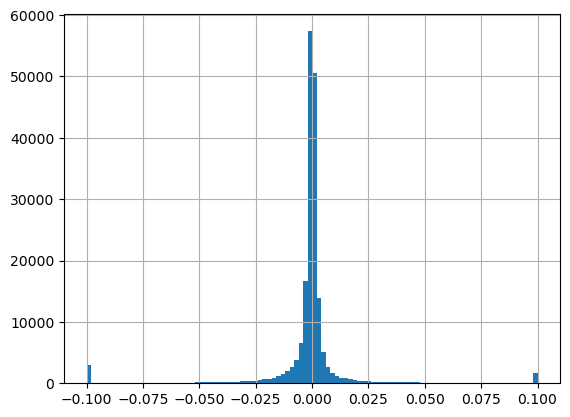

In [111]:
data['target_fee'].hist(bins=100)

In [90]:
params

{'LVR_nbtoken': {'f_min': 0.01, 'f_max': 0.1, 'k': 1.75, 'x0': 1.125},
 'price_diff': {'f_min': 0.01, 'f_max': 0.1, 'k': 1.75, 'x0': 1.125},
 'arb_pnl': {'f_min': 0.01, 'f_max': 0.1, 'k': 1.75, 'x0': 1.125},
 'std': {'f_min': 0.01, 'f_max': 0.1, 'k': 1.75, 'x0': 1.125},
 'mean_rol_amount': {'f_min': 0.01, 'f_max': 0.1, 'k': 1.75, 'x0': 1.125},
 'avg_gas': {'f_min': 0.01, 'f_max': 0.1, 'k': 1.75, 'x0': 1.125},
 'price_impact': {'f_min': 0.01, 'f_max': 0.1, 'k': 1.75, 'x0': 1.125},
 'rol_amountUSD': {'f_min': 0.01, 'f_max': 0.1, 'k': 1.75, 'x0': 1.125},
 'lambda_1min': {'f_min': 0.01, 'f_max': 0.1, 'k': 1.75, 'x0': 1.125},
 'rol_1min_span': {'f_min': 0.01, 'f_max': 0.1, 'k': 1.75, 'x0': 1.125},
 'rol_1m_trade_count': {'f_min': 0.01, 'f_max': 0.1, 'k': 1.75, 'x0': 1.125},
 'lambda_5min': {'f_min': 0.01, 'f_max': 0.1, 'k': 1.75, 'x0': 1.125},
 'rol_5min_span': {'f_min': 0.01, 'f_max': 0.1, 'k': 1.75, 'x0': 1.125},
 'rol_5m_trade_count': {'f_min': 0.01, 'f_max': 0.1, 'k': 1.75, 'x0': 1.125}

<Axes: >

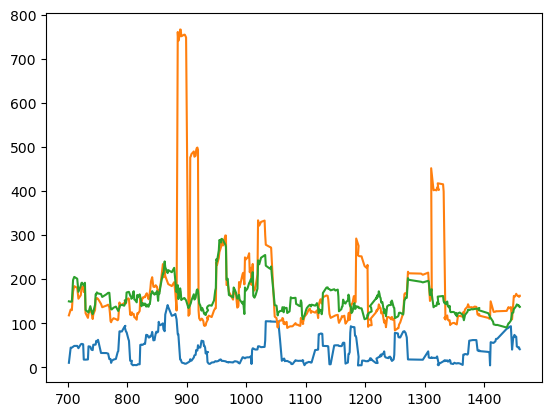

In [112]:
# We can really see that the arbitrage profit theorethical is very linked with the gas payed for transaction on the exchange
# The gas cost is higher that the profits made because we only look at arbitrage on a given pool 
# but usually uniswap alows a multicall if you want to perform a swap transaction accross multiple pools simultanously
# in this you can bundle all the swap into one transaction so you would pay for one tx instead of multiple 
# then arbitragers are also look ing for additional profits on other pools 

(data_filtered['arb_pnl']).abs().rolling(10).sum().head(400).plot()

data_filtered['tcost_usd'].rolling(10).sum().head(400).plot()

# recompute the avg_gas taking all transactions from the block even if they dont want to trade on the pool
data_filtered['avg_gas'].rolling(10).sum().head(400).plot()

<Axes: >

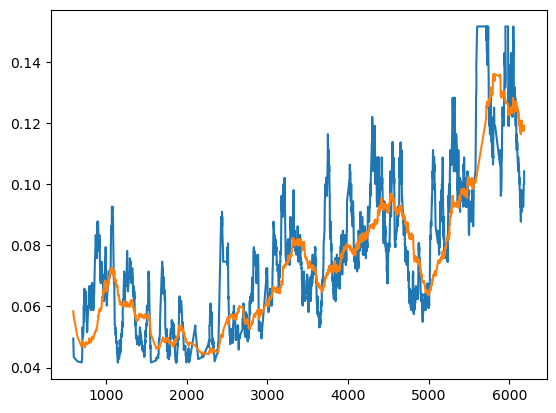

In [113]:
data_filtered['lambda_1min'].head(3000).plot()
data_filtered['lambda_5min'].head(3000).plot()

In [114]:
X = data_filtered[features]
y = data_filtered[target]

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

feature_importances = np.zeros((n_splits, len(features)))

fold = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = RandomForestRegressor(random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    
    feature_importances[fold, :] = model.feature_importances_
    fold += 1

avg_feature_importances = feature_importances.mean(axis=0)

normalized_avg_feature_importances = avg_feature_importances / avg_feature_importances.sum()

# Create a dictionary of features and their normalized average importance
features_importance_normalized_avg = {feature: importance for feature, importance in zip(features, normalized_avg_feature_importances)}
print("\nNormalized Average Feature Importances Across Folds:")
for feature, importance in features_importance_normalized_avg.items():
    print(f"{feature}: {importance:.4f}")



Normalized Average Feature Importances Across Folds:
LVR_nbtoken: 0.0692
price_diff: 0.1357
arb_pnl: 0.0861
std: 0.0671
mean_rol_amount: 0.0733
avg_gas: 0.1622
price_impact: 0.0213
rol_amountUSD: 0.0780
lambda_1min: 0.0331
rol_1min_span: 0.0331
rol_1m_trade_count: 0.0000
lambda_5min: 0.0399
rol_5min_span: 0.0394
rol_5m_trade_count: 0.0000
amountUSD: 0.1617


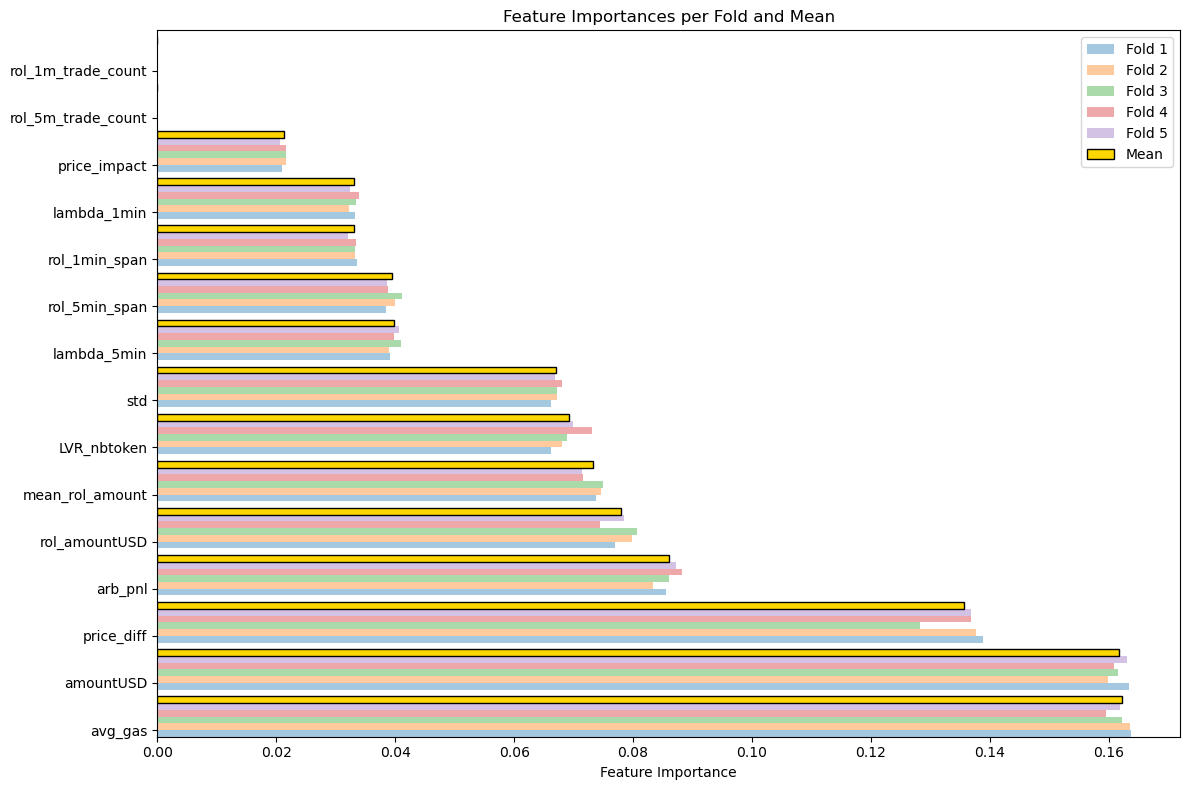

In [115]:
# Compute the mean feature importance and sort features based on it
mean_feature_importances = np.mean(feature_importances, axis=0)
sorted_idx = np.argsort(mean_feature_importances)[::-1]

n_features = len(features)
n_folds = feature_importances.shape[0]
fig, ax = plt.subplots(figsize=(12, 8))

width = 1 / (n_folds + 2)  # +2 for spacing and the mean

# Create a bar plot for each fold's feature importance + mean feature importance
for fold in range(n_folds):
    fold_importances_sorted = feature_importances[fold, sorted_idx]
    ax.barh(np.arange(n_features) - width / 2 + fold * width, fold_importances_sorted, height=width, label=f'Fold {fold+1}', alpha=0.4)

mean_importances_sorted = mean_feature_importances[sorted_idx]
ax.barh(np.arange(n_features) - width / 2 + n_folds * width, mean_importances_sorted, height=width, color='gold', edgecolor='black', label='Mean')

ax.set(yticks=np.arange(n_features), yticklabels=np.array(features)[sorted_idx], ylim=(-width, n_features - width))
ax.set_xlabel('Feature Importance')
ax.set_title('Feature Importances per Fold and Mean')
ax.legend()

plt.tight_layout()
plt.show()


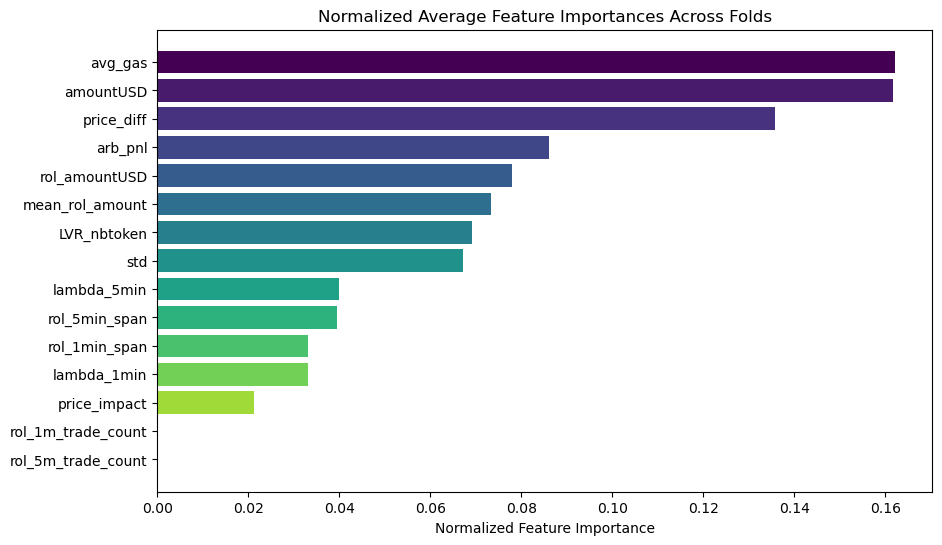

In [116]:
# Assuming 'features_importance_normalized_avg' contains your normalized average feature importances
features = list(features_importance_normalized_avg.keys())
normalized_importances = list(features_importance_normalized_avg.values())

# Sorting features by their importances for better visualization
sorted_indices = sorted(range(len(normalized_importances)), key=lambda i: normalized_importances[i], reverse=True)
sorted_features = [features[i] for i in sorted_indices]
sorted_importances = [normalized_importances[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color=plt.cm.viridis(np.linspace(0, 1, len(features))))
plt.xlabel('Normalized Feature Importance')
plt.title('Normalized Average Feature Importances Across Folds')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


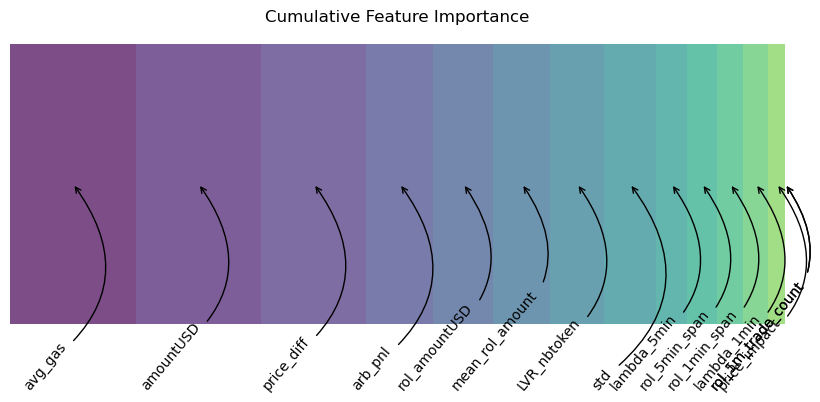

In [117]:
# Assuming 'features_importance_normalized' is your dictionary with your features and their normalized importances
features = list(features_importance_normalized_avg.keys())
importances = list(features_importance_normalized_avg.values())

# Sort features by their importances in descending order
sorted_indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)
sorted_features = [features[i] for i in sorted_indices]
sorted_importances = [importances[i] for i in sorted_indices]

# Plot setup
plt.figure(figsize=(10, 4))  # Adjust the figure size as necessary
cumulative_importances = [sum(sorted_importances[:i+1]) for i in range(len(sorted_importances))]
starts = [0] + cumulative_importances[:-1]  # Starting point for each feature's bar section

# Create a stacked bar plot with annotations
for i, feature in enumerate(sorted_features):
    plt.barh(' ', sorted_importances[i], left=starts[i], color=plt.cm.viridis(i / len(sorted_features)), alpha=0.7)
    # Annotate each bar section with the feature name
    plt.annotate(feature, 
                 xy=(starts[i] + sorted_importances[i] / 2, 0), 
                 xytext=(-20, -150),  # Adjust as needed
                 textcoords="offset points",
                 ha='center', va='bottom',
                 rotation=50,  # Adjust as needed
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5"))

plt.xlabel('Normalized Feature Importance')
plt.title('Cumulative Feature Importance')
plt.xlim(0, 1)  # Ensure the x-axis goes from 0 to 1 to represent the full 100% of importances
plt.axis('off')  # Turn off the axis for a cleaner look
plt.show()


In [156]:
buy_subset = data_filtered[data_filtered['amount1'] < 0].copy()
sell_subset = data_filtered[data_filtered['amount1'] > 0].copy()

for f in features:    
    # here for each features the parameters of the sigmoid will be the one to calibrate
    buy_subset[f'{f}_fee']  = buy_subset[f].apply(lambda x: adjusted_sigmoid(x, params[f]['f_min'], params[f]['f_max'], params[f]['k'], params[f]['x0']))
    sell_subset[f'{f}_fee'] = -sell_subset[f].apply(lambda x: adjusted_sigmoid(-x, params[f]['f_min'], params[f]['f_max'], k, params[f]['x0']))

combined_data = pd.concat([buy_subset, sell_subset])

# Apply feature importances as weights
for f in features:
    weight = features_importance_normalized_avg[f]
    combined_data[f'{f}_weighted_fee'] = combined_data[f'{f}_fee'] * weight

# sum weighted fees to get a combined fee
weighted_fee_columns = [f'{f}_weighted_fee' for f in features]
combined_data['combined_fee'] = combined_data[weighted_fee_columns].sum(axis=1)

combined_data['selling_fee'] = 0 
combined_data['buying_fee']  = 0 

combined_data.loc[combined_data['amount0'] < 0, 'selling_fee'] = combined_data['combined_fee']
combined_data.loc[combined_data['amount1'] < 0, 'buying_fee'] = combined_data['combined_fee']

combined_data['target_fee_usd'] = combined_data['target_fee'] * combined_data['amount0']


In [157]:
# check the fee is correctly computed for each features
combined_data

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,rol_1min_span_weighted_fee,rol_1m_trade_count_weighted_fee,lambda_5min_weighted_fee,rol_5min_span_weighted_fee,rol_5m_trade_count_weighted_fee,amountUSD_weighted_fee,combined_fee,selling_fee,buying_fee,target_fee_usd
596,3454.673405,-1.505838,3457.185832,0xdd601697714d285aee8c1abfa3df7a2da3c5d731,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704078e+09,466191,9.486673e+09,9.486673e-09,...,0.003309,0.0,0.000880,0.003939,0.0,0.016172,0.068135,0.000000,0.068135,5.709819
698,2461.352693,-1.078361,2463.791895,0xe8b55fd62045d51274812e5c3ab803055c0e3eaa,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704080e+09,317787,1.133606e+10,1.133606e-08,...,0.003309,0.0,0.000871,0.003939,0.0,0.016172,0.073308,0.000000,0.073308,5.418473
701,428.908851,-0.187957,429.385012,0x51ecdc62fea43e8596f82ebbe288fed29f909634,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704080e+09,218161,1.110306e+10,1.110306e-08,...,0.003309,0.0,0.000871,0.003939,0.0,0.016172,0.068711,0.000000,0.068711,5.521097
707,406.065421,-0.178114,406.465673,0x51ecdc62fea43e8596f82ebbe288fed29f909634,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704080e+09,218155,1.076158e+10,1.076158e-08,...,0.003309,0.0,0.000872,0.003939,0.0,0.016172,0.068686,0.000000,0.068686,3.412761
709,3435.793337,-1.507049,3439.173193,0xa06c3c08a19e51b33309eddfb356c33ead8517a3,0xe4000004000bd8006e00720000d27d1fa000d43e,0xe4000004000bd8006e00720000d27d1fa000d43e,1.704080e+09,2100000,1.271572e+10,1.271572e-08,...,0.003309,0.0,0.000872,0.003939,0.0,0.016172,0.073990,0.000000,0.073990,13.342030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187216,-22692.042185,9.950000,22688.298245,0x75cd5524a59d570eee410dc36bf2cb0bb8013d59,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706745e+09,331834,2.239705e+10,2.239705e-08,...,-0.000331,-0.0,-0.000791,-0.000394,-0.0,-0.001617,-0.012143,-0.012143,0.000000,25.339898
187217,-150.000000,0.065775,149.978583,0xd132becd2e0a3c5d9d5b4c0fbdcc316ddf1d6e00,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706745e+09,641134,2.110782e+10,2.110782e-08,...,-0.000331,-0.0,-0.000791,-0.000394,-0.0,-0.001617,-0.012996,-0.012996,0.000000,1.897141
187220,-4281.501296,1.877463,4280.921566,0xf865067a5b9672f11af8514440d9111afd05d040,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,606426,2.448898e+10,2.448898e-08,...,-0.000331,-0.0,-0.000791,-0.000394,-0.0,-0.001617,-0.016798,-0.016798,0.000000,6.717651
187221,-16804.135320,7.369011,16802.205053,0x4066e9bd5618373d2da7a1cb7bba03ef800875ee,0x6719c6ebf80d6499ca9ce170cda72beb3f1d1a54,0x6719c6ebf80d6499ca9ce170cda72beb3f1d1a54,1.706746e+09,217474,8.602831e+10,8.602831e-08,...,-0.000331,-0.0,-0.000791,-0.000394,-0.0,-0.001617,-0.015124,-0.015124,0.000000,-27.720447


In [169]:
metrics = combined_data.resample('1Min', on='time_dex').agg({
    'price_dex'           : 'ohlc',
    'amount0'             : 'sum',
    'amount1'             : 'sum',
    'amountUSD'           : 'sum',
    'price_diff'          : 'last',
    'arb_pnl'             : 'sum',
    'price_impact'        : 'sum', # or mean maybe
    'lambda_5min'         : 'last',
    'lambda_1min'         : 'last',
    'impermanent_loss'    : 'sum',
    'tcost_usd'           : 'sum',
    'avg_gas'             : 'mean',
    'target_fee_usd'      : 'mean',
    'combined_fee'        : 'last',
    'selling_fee'         : 'mean',
    'buying_fee'          : 'mean',
})
metrics.columns = metrics.columns.droplevel(0)
metrics = metrics.rename(columns={'amountUSD': 'volumeUSD'})
metrics['1m_volumeUSD'] = metrics['volumeUSD'].rolling(window=60).sum()

metrics['future_close'] = metrics['close'].shift(-60)
metrics = metrics.dropna()

metrics['markout'] = metrics.apply(lambda x: calculate_markout(d=np.sign(x['amount0']), v=x['volumeUSD'], f=x['future_close'], p=x['close']), axis=1)

pool_fee_rate = 0.05/100

metrics['trade_direction'] = np.sign(metrics['amount0'])
metrics['cfee'] = pool_fee_rate * metrics['volumeUSD']
metrics['dfee'] = metrics['combined_fee'] * metrics['volumeUSD']

metrics['cpnl'] = metrics['close'].shift(-1) - metrics['close'] + metrics['cfee'].abs()
metrics['dpnl'] = metrics['close'].shift(-1) - metrics['close'] + metrics['dfee'].abs()

metrics['cfee_cumul'] = metrics['cfee'].cumsum()
metrics['dfee_cumul'] = metrics['dfee'].cumsum()
metrics['avg_7m_cfee'] = (metrics['volumeUSD'] * pool_fee_rate).rolling(window=7).mean()

metrics['cpnl_5m_positive'] = metrics['cpnl'].rolling(window=5).apply(lambda x: np.sum(x[x>0]))
metrics['cpnl_5m_negative'] = metrics['cpnl'].rolling(window=5).apply(lambda x: np.sum(x[x<0]))
# Calculate a 7 min ma of percent toxic flow:
metrics['c%_toxic_flow_ma_7m'] = (metrics['cpnl_5m_negative'].abs() / (metrics['cpnl_5m_negative'] + metrics['cpnl_5m_positive'])).rolling(window=7).mean()

metrics['dpnl_5m_positive'] = metrics['dpnl'].rolling(window=5).apply(lambda x: np.sum(x[x>0]))
metrics['dpnl_5m_negative'] = metrics['dpnl'].rolling(window=5).apply(lambda x: np.sum(x[x<0]))
# Calculate a 7 min ma of percent toxic flow:
metrics['d%_toxic_flow_ma_7m'] = (metrics['dpnl_5m_negative'].abs() / (metrics['dpnl_5m_negative'] + metrics['dpnl_5m_positive'])).rolling(window=7).mean()

metrics.dropna()

,open,high,low,close,amount0,amount1,volumeUSD,price_diff,arb_pnl,price_impact,...,dpnl,cfee_cumul,dfee_cumul,avg_7m_cfee,cpnl_5m_positive,cpnl_5m_negative,c%_toxic_flow_ma_7m,dpnl_5m_positive,dpnl_5m_negative,d%_toxic_flow_ma_7m
time_dex,,,,,,,,,,,,,,,,,,,,,
2024-01-01 04:10:00,2277.004676,2277.004676,2277.004676,2277.004676,-8933.179774,3.926911,15348.035306,0.615324,2.903028,0.000000,...,1067.052031,145.875674,-7.723745e+02,4.349423,14.918246,0.000000,0.000000,2118.439000,0.0,0.0
2024-01-01 04:11:00,2277.004676,2277.004676,2276.776998,2276.776998,-5236.971845,2.301882,7737.612553,0.413002,1.075531,0.029998,...,98.320568,149.744480,-8.706951e+02,4.891580,12.979143,0.000000,0.000000,1393.757317,0.0,0.0
2024-01-01 04:12:00,2276.776998,2276.776998,2276.776998,2276.776998,152.991272,-0.067164,152.975308,0.403002,-0.027067,0.049985,...,8.222774,149.820968,-8.601968e+02,2.727317,12.123623,-2.199038,0.031654,1279.788788,0.0,0.0
2024-01-01 04:13:00,2274.501473,2274.501473,2274.501473,2274.501473,-3365.267927,1.481300,7684.846864,-1.371473,0.178951,0.019997,...,533.572464,153.663391,-3.252601e+02,2.446533,14.538999,-2.199038,0.057111,1811.719687,0.0,0.0
2024-01-01 04:15:00,2272.682690,2273.137250,2272.682690,2273.137250,6263.213919,-2.753999,7536.550705,-0.017250,-2.939900,0.020001,...,106.808021,157.431666,-4.329772e+02,2.862641,16.652594,-2.199038,0.078846,1813.975858,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 22:54:00,2284.302396,2284.302396,2284.302396,2284.302396,5179.996740,-2.266102,7209.276356,0.717604,-2.737315,0.000000,...,93.112141,550233.074416,1.644688e+07,12.117636,70.018836,0.000000,0.000000,4769.306071,0.0,0.0
2024-01-31 22:55:00,2284.302396,2284.530826,2284.302396,2284.302396,-5062.017949,2.219477,15833.687858,0.587604,1.873288,0.029999,...,194.569934,550240.991260,1.644668e+07,12.955592,50.045971,0.000000,0.000000,1303.586392,0.0,0.0
2024-01-31 22:56:00,2284.302396,2284.302396,2282.932294,2282.932294,-6114.961594,2.680165,20674.101858,-0.882294,-1.971230,0.069979,...,1478.102151,550251.328311,1.644816e+07,12.219050,47.287265,0.000000,0.000000,2398.887485,0.0,0.0


<Axes: xlabel='time_dex'>

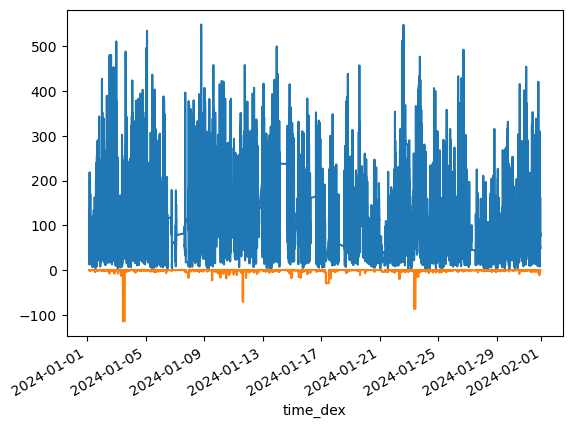

In [159]:
metrics['cpnl_5m_positive'].plot()
metrics['cpnl_5m_negative'].plot()

<Axes: xlabel='time_dex'>

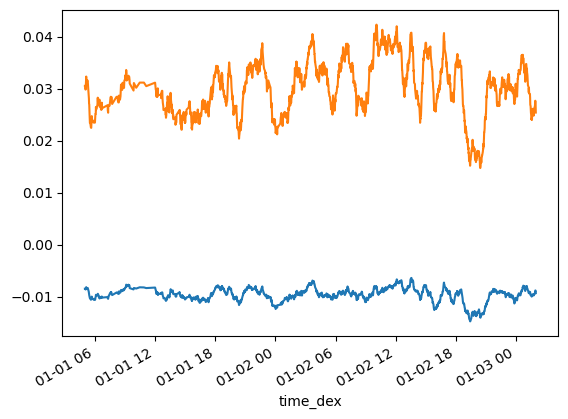

In [170]:
metrics['selling_fee'].rolling(50).mean().head(2000).plot()
metrics['buying_fee'].rolling(50).mean().head(2000).plot()

In [171]:
print(f"The average constant fees is: {0.05}")
average_fee_positive = combined_data[combined_data['amount1'] > 0]['combined_fee'].mean()
average_fee_negative = combined_data[combined_data['amount1'] < 0]['combined_fee'].mean()

print(f"The average dynamic selling fees is: {round(average_fee_positive, 2)}")
print(f"The average dynamic buying  fees is: {round(average_fee_negative, 2)}")
print('')
print(f"The total constant fees are: {round(metrics['cfee'].sum(), 2)}")
print(f"The total dynamic  fees are: {round(metrics['dfee'].sum(), 2)}")
print('')
print(f"The total pnl with c are: {round(metrics['cpnl'].sum(), 2)}")
print(f"The total pnl with d are: {round(metrics['dpnl'].sum(), 2)}")
print('')
print(f"The % of toxic pnl flow in constant fee: {metrics['c%_toxic_flow_ma_7m'].sum().round(2)}")
print(f"The % of toxic pnl flow in dynamic  fee: {metrics['d%_toxic_flow_ma_7m'].sum().round(2)}")
print('')
print('The 1 min markout pnl is: ', round(metrics['markout'].sum(), 2))
print('')
print('The impermanent loss is : ', round(metrics['impermanent_loss'].sum(), 2))
print('')
print('Average tcost_usd     : ', round(metrics['tcost_usd'].mean(), 2))
print('Average target_fee_usd: ', round(metrics['target_fee_usd'].mean(), 2))
print('')
print('Average combined_fee  : ', round(metrics['combined_fee'].abs().mean(), 2))
weighted_fee = (combined_data['amountUSD'] * combined_data['combined_fee'].abs())/combined_data['amountUSD'].sum()
print('Average weighted_fee  : ', round(weighted_fee.mean(), 5))
print('Average selling_fee   : ', round(metrics['selling_fee'].abs().mean(), 2))
print('Average buying_fee    : ', round(metrics['buying_fee'].abs().mean(), 2))

# only 9% of the fees that we quote are in the range of the fee the arbitrager will be willing to pay
accuracy = (metrics['avg_gas'] + metrics['dfee'].abs() < metrics['tcost_usd']).mean()

print(f'{accuracy*100:.2f}% of the dynamic fees are in the range of the constant fee the arbitrager will be willing to pay')
print('Average accuracy of the fee: ', round(accuracy*100, 2))

# can we know whats gonna be the price impact after this dynamic fee:
# we need to now what will be the liquidity in such pools at the permanent regime 
# this will depend on the profitability (returns of LP) of LP. 
# In average the liquidty is provided in a pool such that the returns are the same as a constant pool 
# we can then match the liquidity corresponding to this profitability and find the price impact at a given liquidity level for a given amount to swap

The average constant fees is: 0.05
The average dynamic selling fees is: -0.02
The average dynamic buying  fees is: 0.07

The total constant fees are: 550352.58
The total dynamic  fees are: 16449476.89

The total pnl with c are: 550290.71
The total pnl with d are: 41193398.26

The % of toxic pnl flow in constant fee: 2908.76
The % of toxic pnl flow in dynamic  fee: 0.13

The 1 min markout pnl is:  675209296.75

The impermanent loss is :  -0.0

Average tcost_usd     :  74.52
Average target_fee_usd:  9.01

Average combined_fee  :  0.04
Average weighted_fee  :  0.0
Average selling_fee   :  0.01
Average buying_fee    :  0.03
10.37% of the dynamic fees are in the range of the constant fee the arbitrager will be willing to pay
Average accuracy of the fee:  10.37


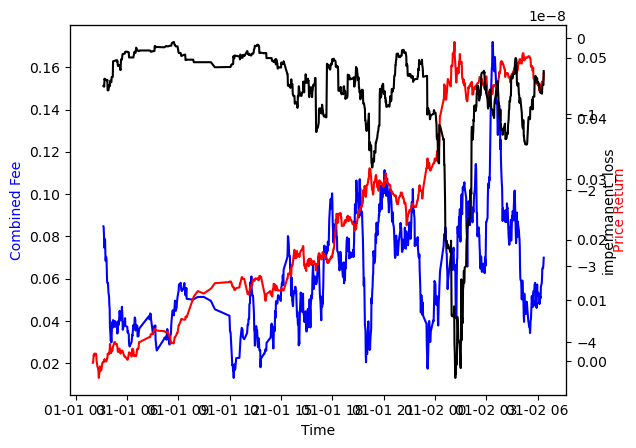

In [135]:
# after aggregating the swap on a minute level here is the time series of the fee we charge
n = 1000
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax1.plot(metrics['combined_fee'].rolling(30).mean().head(n), color='blue')
ax2.plot(metrics['close'].pct_change().cumsum().head(n), color='red')
ax3.plot(metrics['impermanent_loss'].rolling(30).mean().head(n), color='black')

ax1.set_xlabel('Time')
ax1.set_ylabel('Combined Fee', color='blue')
ax2.set_ylabel('Price Return', color='red')
ax3.set_ylabel('impermanent_loss', color='black')
plt.show()


In [17]:
# plot correlation of the dynamic fee with the factore we consider in the model
# plot also the temporal rolling graphs of the features and the fees to see they mve together

In [126]:
agg_sender = combined_data[['arb_pnl', 'sender']].groupby('sender').sum()
agg_origin = combined_data[['arb_pnl', 'origin']].groupby('origin').sum()
agg_recipient = combined_data[['arb_pnl', 'recipient']].groupby('recipient').sum()

pnl_dico = {}

for df in [agg_sender, agg_origin, agg_recipient]:
    for address, arb_pnl in zip(df.index, df['arb_pnl']):
        if address in pnl_dico:
            pnl_dico[address] += arb_pnl
        else:
            pnl_dico[address] = arb_pnl

# filter addresses trading with positive LVR return 
s = 3 # np.std(list(pnl_dico.values())) 
pnl_dico = {address: pnl for address, pnl in pnl_dico.items() if pnl > 5}
dic_fee = {address: adjusted_sigmoid(np.tanh(pnl/s), f_min, f_max, k, (f_max-f_min)/(2*w)) for address, pnl in pnl_dico.items()}
len(dic_fee)

2235

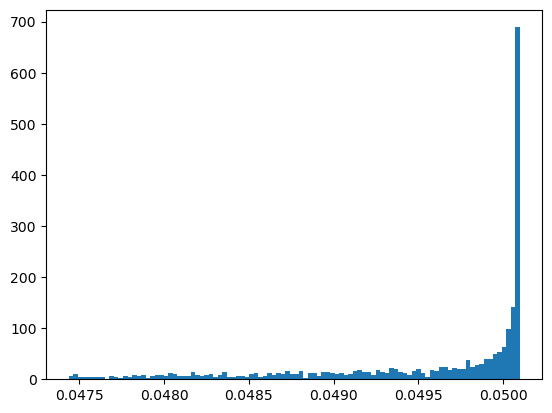

In [128]:
plt.hist([x for x in dic_fee.values()], bins=100)
plt.show()

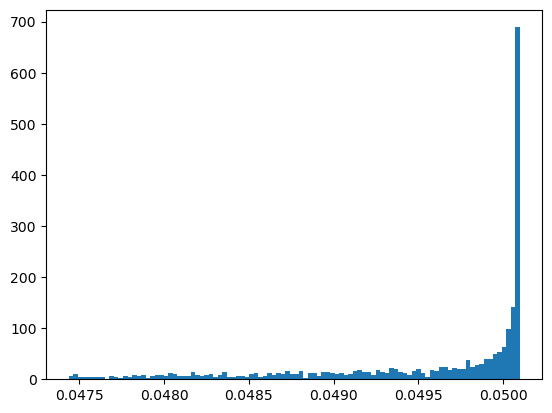

In [127]:
s = np.std(list(pnl_dico.values()))
m = np.mean(list(pnl_dico.values()))
# plt.hist([sigmoid((x-m)/s) for x in pnl_dico.values()], bins=100)
# plt.hist([np.tanh(x/s) for x in pnl_dico.values()], bins=100)
plt.hist([x for x in dic_fee.values()], bins=100)
plt.show()

In [20]:
please = pd.DataFrame.from_dict(dic_fee, orient='index', columns=['fees'])
please = please.reset_index().rename(columns={'index': 'address'}).sort_values(by='fees', ascending=False)

merged_data = combined_data.merge(please.rename(columns={'fees' : 'f1'}), left_on='sender', how='left', right_on='address')
merged_data = merged_data.merge(please.rename(columns={'fees' : 'f2'}), left_on='origin', how='left', right_on='address')
merged_data = merged_data.merge(please.rename(columns={'fees' : 'f3'}), left_on='recipient', how='left', right_on='address')

merged_data[['f1', 'f2', 'f3']] = merged_data[['f1', 'f2', 'f3']].fillna(0).clip(lower=0.05)

merged_data['mean_fee'] = merged_data[['f1', 'f2', 'f3']].mean(axis=1) 

merged_data = merged_data.drop(columns=['address_x', 'address_y', 'address', 'f1', 'f2', 'f3']).fillna(0.5)

merged_data

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,lambda_1min_weighted_fee,rol_1min_span_weighted_fee,rol_1m_trade_count_weighted_fee,lambda_5min_weighted_fee,rol_5min_span_weighted_fee,rol_5m_trade_count_weighted_fee,amountUSD_weighted_fee,combined_fee,target_fee_usd,mean_fee
0,6318.571324,-2.753365,6310.474821,0xf3e01e963796ad8ed86fc7dbce195eaa3aaf4e4a,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,414642,1.216669e+10,1.216669e-08,...,0.000603,0.002680,0.0,0.000763,0.003497,7.132124e-08,0.007451,0.060524,14.637796,0.083333
1,1500.000000,-0.653642,1498.084492,0xfcb40a45a51a31f568ef39e0f6dfe5f3b21711df,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,303561,1.095438e+10,1.095438e-08,...,0.000603,0.002680,0.0,0.000762,0.003497,7.132124e-08,0.007451,0.061986,10.190651,0.083333
2,1000.000000,-0.435761,998.722184,0xa6f73764fed1a058a328c0a4740053809f07875d,0xf3de3c0d654fda23dad170f0f320a92172509127,0xf3de3c0d654fda23dad170f0f320a92172509127,1.704069e+09,286452,1.196813e+10,1.196813e-08,...,0.000604,0.002680,0.0,0.000762,0.003497,7.132124e-08,0.007451,0.062212,8.676795,0.100000
3,5424.689830,-2.363860,5417.751182,0x00903f96abe2743b81fc7fcf4874c715a3fe1c88,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,363346,1.127149e+10,1.127149e-08,...,0.000603,0.002680,0.0,0.000761,0.003497,7.132124e-08,0.007451,0.068059,14.813369,0.099999
4,1000.000000,-0.435970,998.961356,0x652c814acf2334fa1cd30414b00b704986548004,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704069e+09,282193,1.068151e+10,1.068151e-08,...,0.000603,0.002680,0.0,0.000760,0.003497,7.132124e-08,0.007451,0.060532,9.807700,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187122,-150.000000,0.065775,149.978583,0xd132becd2e0a3c5d9d5b4c0fbdcc316ddf1d6e00,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706745e+09,641134,2.110782e+10,2.110782e-08,...,-0.000551,-0.000268,-0.0,-0.000679,-0.000350,-7.132124e-09,-0.000745,-0.014224,5.259603,0.083333
187123,-47438.602771,20.800000,47429.790306,0x0b7c57a13b1fcf185cbdf40382c721429b4352f0,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706745e+09,345666,2.350034e+10,2.350034e-08,...,-0.000551,-0.000268,-0.0,-0.000679,-0.000350,-7.132124e-09,-0.000745,-0.012892,33.252802,0.100000
187124,-4281.501296,1.877463,4280.921566,0xf865067a5b9672f11af8514440d9111afd05d040,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,606426,2.448898e+10,2.448898e-08,...,-0.000552,-0.000268,-0.0,-0.000679,-0.000350,-7.132124e-09,-0.000745,-0.019207,1.375802,0.083333
187125,-16804.135320,7.369011,16802.205053,0x4066e9bd5618373d2da7a1cb7bba03ef800875ee,0x6719c6ebf80d6499ca9ce170cda72beb3f1d1a54,0x6719c6ebf80d6499ca9ce170cda72beb3f1d1a54,1.706746e+09,217474,8.602831e+10,8.602831e-08,...,-0.000552,-0.000268,-0.0,-0.000679,-0.000350,-7.132124e-09,-0.000745,-0.016979,-29.449351,0.100000


<Axes: >

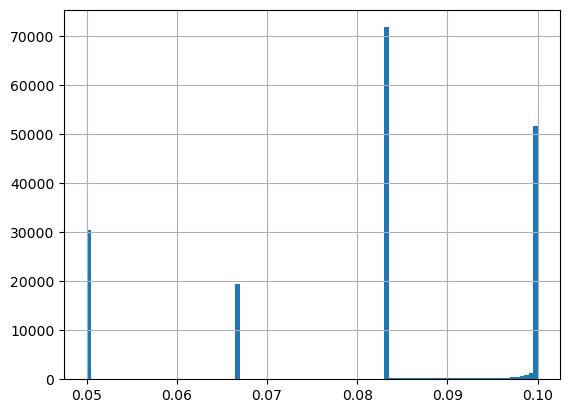

In [21]:
merged_data.mean_fee.hist(bins=100)

In [129]:
# calib k:
from scipy.optimize import minimize

def buy_fee(x,  f_min, f_max, w_buy):
    return min(f_max, f_min + w_buy * max(0, x))

def sell_fee(x,  f_min, f_max, w_sell):
    return min(f_max, f_min - w_sell * min(0, x))

def adjusted_sigmoid(x, f_min, f_max, k, x0):
    return f_min + (f_max - f_min) / (1 + np.exp(-k * (x - x0)))

def cost_function_buy(k, delta_ps, f_min, f_max, w_buy, x0):
    sigmoid_fees = np.array([adjusted_sigmoid(x, f_min, f_max, k, x0) for x in delta_ps])
    linear_fees = np.array([buy_fee(x,  f_min, f_max, w_buy) for x in delta_ps])
    return np.sum((sigmoid_fees - linear_fees) ** 2)

def cost_function_sell(k, delta_ps, f_min, f_max, w_sell, x0):
    sigmoid_fees = np.array([adjusted_sigmoid(-x, f_min, f_max, k, x0) for x in delta_ps])
    linear_fees = np.array([sell_fee(x,  f_min, f_max, w_sell) for x in delta_ps])
    return np.sum((sigmoid_fees - linear_fees) ** 2)

In [23]:
features

['LVR_nbtoken',
 'price_diff',
 'arb_pnl',
 'std',
 'mean_rol_amount',
 'avg_gas',
 'price_impact',
 'rol_amountUSD',
 'lambda_1min',
 'rol_1min_span',
 'rol_1m_trade_count',
 'lambda_5min',
 'rol_5min_span',
 'rol_5m_trade_count',
 'amountUSD']

Optimized k for buying fees : 28.119416426277912
Optimized k for selling fees: 107.61298025943584


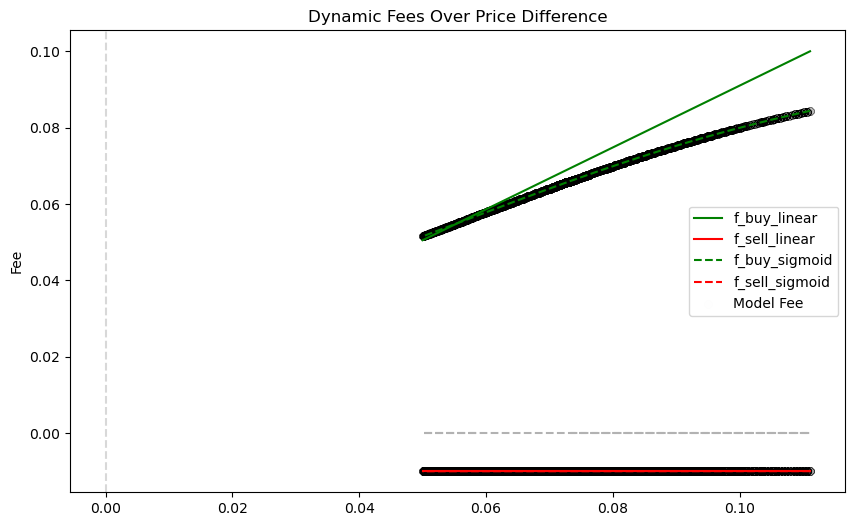

In [130]:
feat = 'lambda_5min' # 'arb_pnl'
f_min  = 0.01
f_max  = 0.1
low_q  = 0.05
high_q = 0.95


scale_min = data_filtered[feat].quantile(high_q)
scale_max = data_filtered[feat].quantile(low_q)
delta_p = pd.DataFrame({'delta_p': np.linspace(scale_min, scale_max, 1000)})

## !! the price difference is stationnary because we cans stipulate the the dex and cex price are stationnary wich makes total sense 
# cause they are the same asset and arrbitragers always move to remove the differnce
# Then we dont really need to care of using the zscore also because we will redo a different calibration for a different pair 
# (so we dont need to normalize the time series of the difference)


# Segment the data based on 'amount1'
buy_subset = data_filtered[data_filtered['amount1'] < 0].copy()
sell_subset = data_filtered[data_filtered['amount1'] > 0].copy()

if len(sell_subset[sell_subset[feat]<0])>0:
    sell_max_fee_q = sell_subset[sell_subset[feat]<0][feat].quantile(low_q)
    sell_min_fee_q = sell_subset[sell_subset[feat]<0][feat].quantile(high_q)
else :
    sell_max_fee_q = sell_subset[sell_subset[feat]>0][feat].quantile(low_q)
    sell_min_fee_q = sell_subset[sell_subset[feat]>0][feat].quantile(high_q)
    
if len(buy_subset[buy_subset[feat]>0])>0:
    buy_max_fee_q  = buy_subset[buy_subset[feat]>0][feat].quantile(low_q)
    buy_min_fee_q  = buy_subset[buy_subset[feat]>0][feat].quantile(high_q)
else:
    buy_max_fee_q  = buy_subset[buy_subset[feat]<0][feat].quantile(low_q)
    buy_min_fee_q  = buy_subset[buy_subset[feat]<0][feat].quantile(high_q)

w_buy  = np.abs((f_max-f_min)/buy_min_fee_q)
w_sell = np.abs((f_max-f_min)/sell_max_fee_q)

x0_sell = np.abs(sell_max_fee_q/2)
x0_buy = np.abs(buy_min_fee_q/2)

delta_ps = np.linspace(scale_min, scale_max, 1000)
result_buy  = minimize(cost_function_buy,  1, args=(delta_ps, f_min, f_max, w_buy,  x0_buy))
result_sell = minimize(cost_function_sell, 1, args=(delta_ps, f_min, f_max, w_sell, x0_sell))

k_buy  = result_buy.x[0]
k_sell = result_sell.x[0]

print(f"Optimized k for buying fees : {k_buy}")
print(f"Optimized k for selling fees: {k_sell}")

# Apply the fees
buy_subset['model_fee'] = buy_subset[feat].apply(lambda x: adjusted_sigmoid(x, f_min, f_max, k_buy, x0_buy))
sell_subset['model_fee'] = -sell_subset[feat].apply(lambda x: adjusted_sigmoid(-x, f_min, f_max, k_sell, x0_sell))

combined_data = pd.concat([buy_subset, sell_subset])

# plot the fees and the model fee
plt.figure(figsize=(10, 6))

plt.plot(delta_p['delta_p'],  delta_p['delta_p'].apply(lambda x: min(f_max, f_min + w_buy * max(0, x))),  label='f_buy_linear', color='green')
plt.plot(delta_p['delta_p'], -delta_p['delta_p'].apply(lambda x: min(f_max, f_min - w_sell * min(0, x))), label='f_sell_linear', color='red')
plt.plot(delta_p['delta_p'],  delta_p['delta_p'].apply(lambda x: adjusted_sigmoid(x,  f_min, f_max, k_buy,  x0_buy)),  label='f_buy_sigmoid',  linestyle='--', color='green')
plt.plot(delta_p['delta_p'], -delta_p['delta_p'].apply(lambda x: adjusted_sigmoid(-x, f_min, f_max, k_sell, x0_sell)), label='f_sell_sigmoid', linestyle='--', color='red')

filtered_plot = (combined_data[feat] >= combined_data[feat].quantile(low_q)) & (combined_data[feat] <= combined_data[feat].quantile(high_q))
plt.scatter(combined_data[filtered_plot][feat], combined_data[filtered_plot]['model_fee'], alpha=0.005, color='black', label='Model Fee')

plt.plot(combined_data[filtered_plot][feat], [0]*len(combined_data[filtered_plot]), linestyle='--', alpha=0.3, color='black')
plt.axvline(0, color='gray', linestyle='--', alpha=0.3) 

plt.ylabel('Fee')
plt.legend()
plt.title('Dynamic Fees Over Price Difference')
plt.show()

In [25]:
## look in average the final combined fee, how much greater than the base fee it is

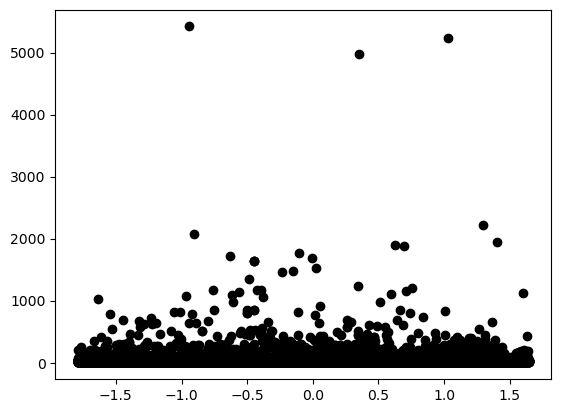

In [134]:
plt.scatter(combined_data['price_diff'], combined_data['tcost_usd'], alpha=1, color='black', label='Model Fee')
